# Data processing for single window bump hunt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from helpers.plotting import *
from helpers.physics_functions import get_bins
from helpers.stats_functions import parametric_fit, curve_fit_m_inv, calculate_test_statistic
from helpers.data_transforms import logit_transform

plt.style.use("../science.mplstyle")

In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

save_data = False

In [3]:

processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data/"
os.makedirs(processed_data_dir, exist_ok = True)

feature_set_to_save = workflow["feature_sets"]["mix_2"]
feature_set_to_save.append("dimu_mass")

print(feature_set_to_save)

['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


In [4]:
bootstrap_seed = 0

working_dir = workflow["file_paths"]["working_dir"]
path_to_compiled_data = workflow["file_paths"]["data_storage_dir"]+"/compiled_data/"+workflow["analysis_keywords"]["dataset_id"]
    
codes_list = ["skimmed_data_2016H_30555_nojet"] # may want multiple codes for injection studies


uncut_data_OS, uncut_data_SS = {code:{} for code in codes_list},  {code:{} for code in codes_list}




for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        tmp_dict = pickle.load(ifile)
        for key in tmp_dict.keys():
            if "samesign" in key:
                uncut_data_SS[code][key[:-9]] = tmp_dict[key]
            else:
                uncut_data_OS[code][key] = tmp_dict[key]

    print(code, "opp sign",  uncut_data_OS[code][list(uncut_data_OS[code].keys())[0]].shape)
    print(code, "same sign", uncut_data_SS[code][list(uncut_data_SS[code].keys())[0]].shape)

skimmed_data_2016H_30555_nojet opp sign (21803668,)
skimmed_data_2016H_30555_nojet same sign (6756613,)


In [5]:
feature_set = list(uncut_data_OS[codes_list[0]].keys())
feature_set = [x for x in feature_set if "HLT" not in x]
print(feature_set)

['dimu_pt', 'dimu_eta', 'dimu_phi', 'n_muons', 'n_jets', 'dimu_mass', 'mu0_ip3d', 'mu1_ip3d', 'mu0_jetiso', 'mu1_jetiso', 'mu0_eta', 'mu1_eta', 'mu0_pt', 'mu1_pt', 'mu0_phi', 'mu1_phi', 'mu0_iso04', 'mu1_iso04', 'mumu_deltaR', 'mumu_deltapT']


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)


In [6]:
SB_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_left"])
SR_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_left"])
SR_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_right"])
SB_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_right"])


band_bounds = {"SBL": [SB_left,SR_left],
                   "SR": [SR_left,SR_right],
                   "SBH": [SR_right,SB_right],
                           }

print(band_bounds)

cut_data_OS, cut_data_SS = {code:{} for code in codes_list},  {code:{} for code in codes_list}


analysis_cuts_dict = workflow["analysis_keywords"]["analysis_cuts"]

for code in codes_list:

    pass_indices_OS = np.ones((uncut_data_OS[code]["dimu_mass"].shape[0]))
    pass_indices_SS = np.ones((uncut_data_SS[code]["dimu_mass"].shape[0]))
    try:
        a = analysis_cuts_dict["lower"].keys()
        for cut_var in analysis_cuts_dict["lower"].keys():
            pass_indices_OS = np.logical_and(pass_indices_OS, uncut_data_OS[code][cut_var] >= analysis_cuts_dict["lower"][cut_var])
            pass_indices_SS = np.logical_and(pass_indices_SS, uncut_data_SS[code][cut_var] >= analysis_cuts_dict["lower"][cut_var])
    except:
        pass
    try:
        a = analysis_cuts_dict["upper"].keys()
        for cut_var in analysis_cuts_dict["upper"].keys():
            pass_indices_OS = np.logical_and(pass_indices_OS, uncut_data_OS[code][cut_var] <= analysis_cuts_dict["upper"][cut_var])
            pass_indices_SS = np.logical_and(pass_indices_SS, uncut_data_SS[code][cut_var] <= analysis_cuts_dict["upper"][cut_var])
    except:
        pass
        
    pass_indices_OS = np.logical_and(pass_indices_OS, (uncut_data_OS[code]["dimu_mass"] >= SB_left) & (uncut_data_OS[code]["dimu_mass"] <= SB_right))
    pass_indices_SS = np.logical_and(pass_indices_SS, (uncut_data_SS[code]["dimu_mass"] >= SB_left) & (uncut_data_SS[code]["dimu_mass"] <= SB_right))


    # apply cuts to oppsign
    for feat in feature_set:
        cut_data_OS[code][feat] = uncut_data_OS[code][feat][pass_indices_OS]
        cut_data_SS[code][feat] = uncut_data_SS[code][feat][pass_indices_SS]
    
    print(f"{code} OS has shape {cut_data_OS[code][feat].shape} after cuts")
    print(f"{code} SS has shape {cut_data_SS[code][feat].shape} after cuts")
    
    


{'SBL': [5.0, 9.0], 'SR': [9.0, 10.6], 'SBH': [10.6, 16.0]}
skimmed_data_2016H_30555_nojet OS has shape (12333,) after cuts
skimmed_data_2016H_30555_nojet SS has shape (7168,) after cuts


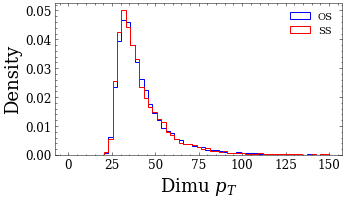

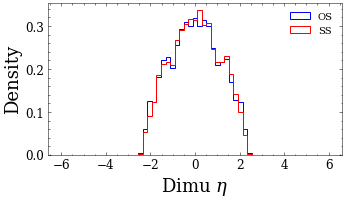

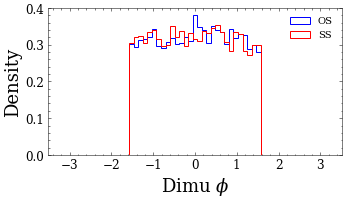

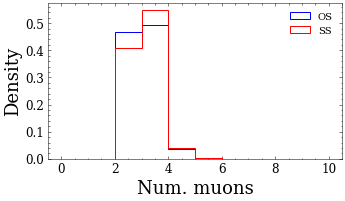

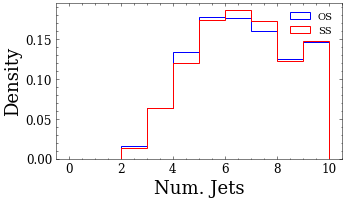

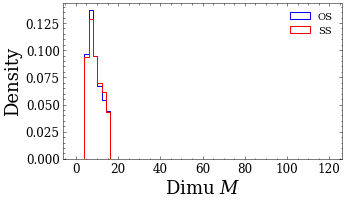

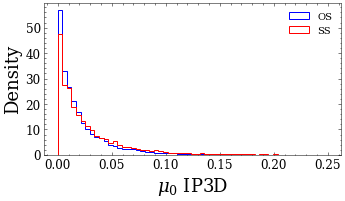

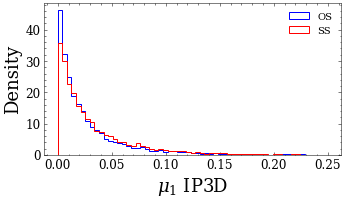

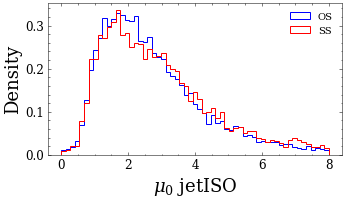

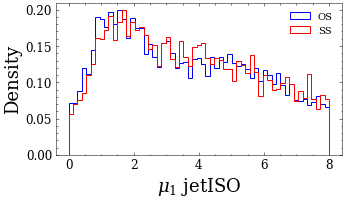

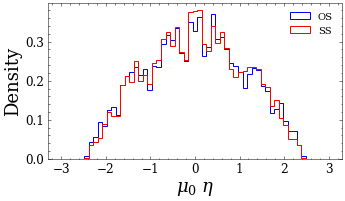

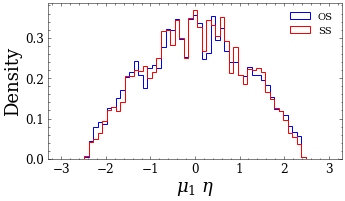

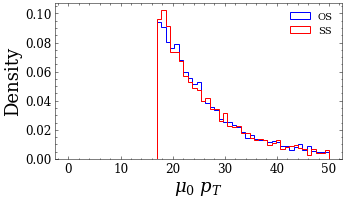

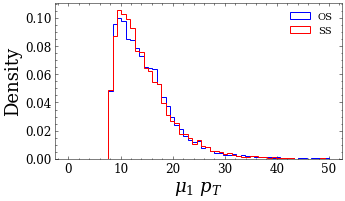

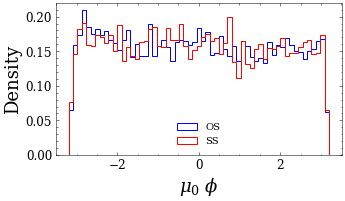

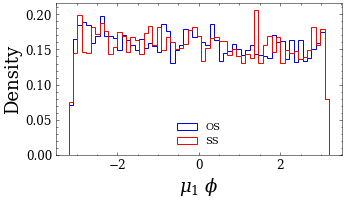

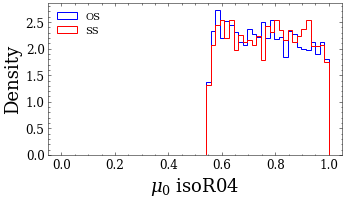

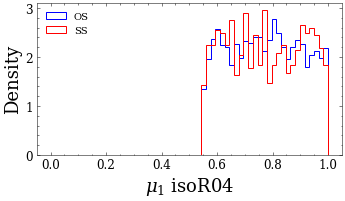

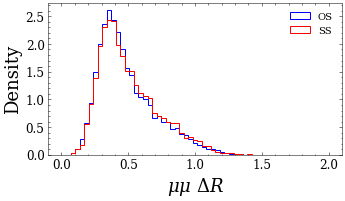

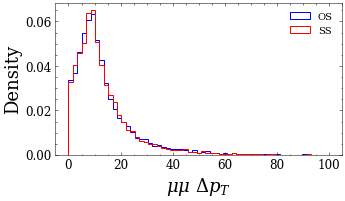

In [7]:
kwargs_dict_dtype = {"OS":{"density": True, "histtype": "step", "color":"blue", "label": "OS"},
                    "SS":{"density": True, "histtype": "step", "color":"red", "label": "SS"}}
        
hist_all_features_dict([cut_data_OS[codes_list[0]], cut_data_SS[codes_list[0]]], ["OS", "SS"], feature_set, kwargs_dict_dtype, nice_labels=True)


Check how local cuts affect the starting significance

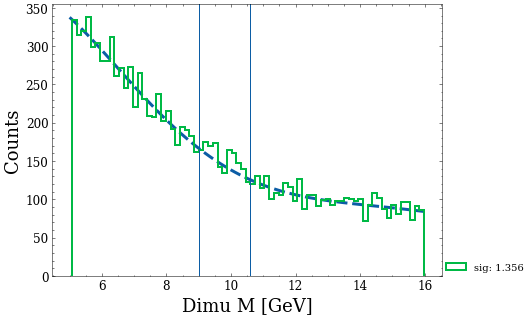

In [8]:
bkg_fit_degree = 5
num_bins_SR = 12
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR= num_bins_SR)

x = np.linspace(SB_left, SB_right, 100) # plot curve fit

plt.figure(figsize = (7,5))

# curve fit the data
popt_0, _, _, _, _ = curve_fit_m_inv(cut_data_OS[code]["dimu_mass"], bkg_fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
# plot the best fit curve
# cßalculate the test statistic
plt.plot(x, parametric_fit(x, *popt_0), lw = 3, linestyle = "dashed")
S, B, q0 = calculate_test_statistic(cut_data_OS[code]["dimu_mass"], SR_left, SR_right, SB_left, SB_right, degree = bkg_fit_degree, starting_guess = popt_0)

# plot all data
plt.hist(cut_data_OS[code]["dimu_mass"], bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = f"sig: {round(np.sqrt(q0),3)}")

plt.axvline(SR_left)
plt.axvline(SR_right)

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))

plt.show()


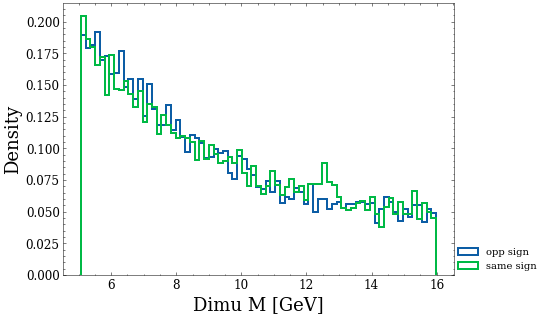

In [9]:

plt.figure(figsize = (7,5))

# plot all data
plt.hist(cut_data_OS[code]["dimu_mass"], bins = plot_bins_all, lw = 2, histtype = "step", density = True, label = f"opp sign")
plt.hist(cut_data_SS[code]["dimu_mass"], bins = plot_bins_all, lw = 2, histtype = "step", density = True, label = f"same sign")
plt.xlabel("Dimu M [GeV]")
plt.ylabel("Density")
plt.legend(loc = (1, 0))
plt.show()
 


Split data into bands

In [10]:
bands = ["SBL", "SR", "SBH"]
N_total_events_OS = 0
N_total_events_SS = 0


preproc_dicts_OS, preproc_dicts_SS = {b:{} for b in bands}, {b:{} for b in bands}


for code in codes_list:
    for b in bands:

        # opp sign
        loc_pass_indices_OS = (cut_data_OS[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_OS[code]["dimu_mass"] < band_bounds[b][1])
        preproc_dicts_OS[b][code] = {}
        for feat in feature_set:
            preproc_dicts_OS[b][code][feat] = cut_data_OS[code][feat][loc_pass_indices_OS]
            
       
        N_total_events_OS += preproc_dicts_OS[b][code][feat].shape[0]
        
        # same sign
        loc_pass_indices_SS = (cut_data_SS[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_SS[code]["dimu_mass"] < band_bounds[b][1])
        preproc_dicts_SS[b][code] = {}
        for feat in feature_set:
            preproc_dicts_SS[b][code][feat] = cut_data_SS[code][feat][loc_pass_indices_SS]
            
        N_total_events_SS += preproc_dicts_SS[b][code][feat].shape[0]
  
    
    
print(f"Total events opp sign: {N_total_events_OS}")
print(f"Total events same sign: {N_total_events_SS}")
    

Total events opp sign: 12332
Total events same sign: 7168


In [11]:
if save_data:
    with open("/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_12_03/processed_data/data_noIsoCut_noPreproc_OS_test_band_data", "wb") as ofile:
        pickle.dump(preproc_dicts_OS, ofile)
    with open("/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_12_03/processed_data/data_noIsoCut_noPreproc_SS_test_band_data", "wb") as ofile:
        pickle.dump(preproc_dicts_SS, ofile)



## Preprocessing

Standard scaling is fine

In [12]:
from sklearn.preprocessing import StandardScaler

sizes_dict_OS, sizes_dict_SS = {}, {}

preprocessing_info = {}
proccessed_data_dict_OS, proccessed_data_dict_SS  = {b:{} for b in bands}, {b:{} for b in bands}

cushion = 0.02
for feat in feature_set_to_save:

    print(f"Preprocessing feature {feat}...")
    
    # train the preprocessor on the opp sign data only
    data_SB = np.hstack((preproc_dicts_OS["SBL"][code][feat], preproc_dicts_OS["SBH"][code][feat])).reshape(-1, 1)
    
    if feat == "dimu_mass": # don't logit transform
        mass_scaler = StandardScaler()
        mass_scaler = mass_scaler.fit(data_SB)
      
        if save_data:
            with open(f"{processed_data_dir}/mass_scaler_bootstrap{bootstrap_seed}", "wb") as ofile:
                pickle.dump(mass_scaler, ofile)

        for b in bands:
            proccessed_data_dict_OS[b][feat] = mass_scaler.transform(preproc_dicts_OS[b][code][feat].reshape(-1,1))
            proccessed_data_dict_SS[b][feat] = mass_scaler.transform(preproc_dicts_SS[b][code][feat].reshape(-1,1))
            sizes_dict_OS[b] = proccessed_data_dict_OS[b][feat].shape[0]
            sizes_dict_SS[b] = proccessed_data_dict_SS[b][feat].shape[0]
    
    else:   
        data_all = np.hstack((preproc_dicts_OS["SBL"][code][feat], preproc_dicts_OS["SBH"][code][feat], preproc_dicts_OS["SR"][code][feat])).reshape(-1, 1)
        
        all_min = np.min(data_all)
        all_max = np.max(data_all)

        if all_min < 0:
            all_min *= 1.0
        else:
            all_min *= 1.0

        if all_max < 0:
            all_max *= 1.0
        else:
            all_max *= 1.2

      
        # logit transform the features      
        transformed_feats = logit_transform(data_SB, all_min, all_max, cushion)
        # subtract off mean, std of the training set
        mean_to_sub = np.mean(transformed_feats)
        std_to_sub = np.std(transformed_feats)
        
        preprocessing_info[feat] = {"mean":mean_to_sub, "std":std_to_sub, "min":all_min, "max":all_max}

        for b in bands:
           
            proccessed_data_dict_OS[b][feat] = (logit_transform(preproc_dicts_OS[b][code][feat], all_min, all_max, cushion) - mean_to_sub)/std_to_sub
            proccessed_data_dict_SS[b][feat] = (logit_transform(preproc_dicts_SS[b][code][feat], all_min, all_max, cushion) - mean_to_sub)/std_to_sub

if save_data:
    with open(f"{processed_data_dir}/preprocessing_info_bootstrap{bootstrap_seed}", "wb") as ofile:
                pickle.dump(preprocessing_info, ofile)


Preprocessing feature dimu_pt...
Preprocessing feature mu0_ip3d...
Preprocessing feature mu1_ip3d...
Preprocessing feature dimu_mass...


In [13]:
print(sizes_dict_OS)
print(sizes_dict_SS)

{'SBL': 6924, 'SR': 1692, 'SBH': 3716}
{'SBL': 3868, 'SR': 989, 'SBH': 2311}


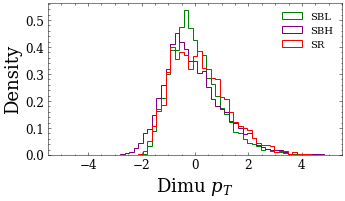

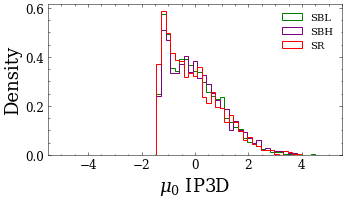

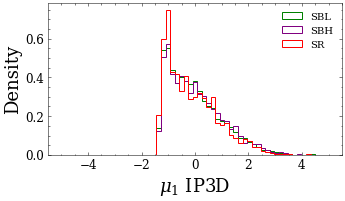

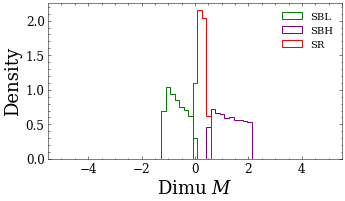

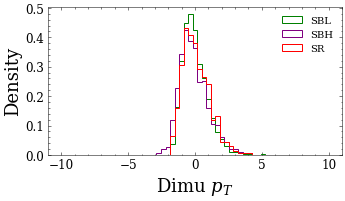

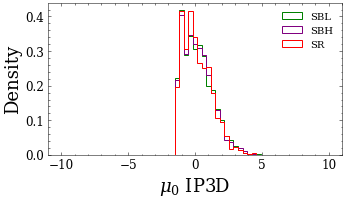

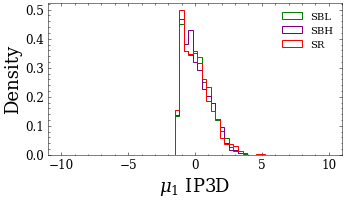

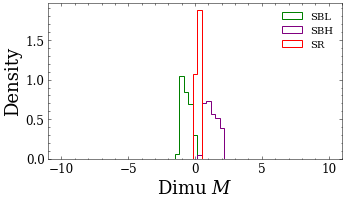

In [14]:
hist_all_features_dict([proccessed_data_dict_OS["SBL"], proccessed_data_dict_OS["SBH"], proccessed_data_dict_OS["SR"]], 
                       ["SBL", "SBH", "SR"], feature_set_to_save, kwargs_dict_bands, scaled_features=True, plot_bound=5, image_path=None, yscale_log=False, nice_labels=True)


hist_all_features_dict([proccessed_data_dict_SS["SBL"], proccessed_data_dict_SS["SBH"], proccessed_data_dict_SS["SR"]], 
                       ["SBL", "SBH", "SR"], feature_set_to_save, kwargs_dict_bands, scaled_features=True, plot_bound=10, image_path=None, yscale_log=False, nice_labels=True)





In [15]:

trial_test_set = mass_scaler.inverse_transform(np.concatenate((proccessed_data_dict_OS["SBL"]["dimu_mass"], proccessed_data_dict_OS["SBH"]["dimu_mass"], proccessed_data_dict_OS["SR"]["dimu_mass"])))


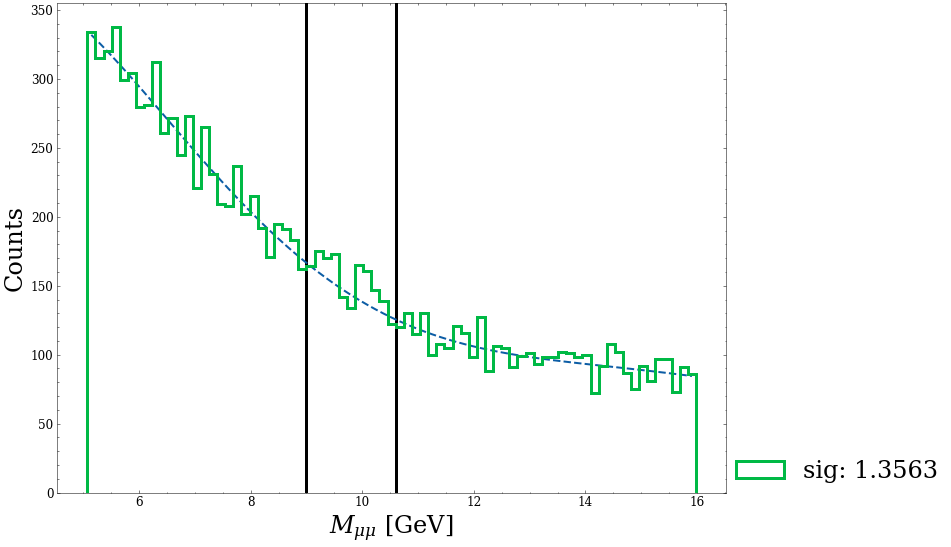

In [16]:
plt.figure(figsize = (12, 9))


# get the fit function to SB background

# plot the best fit curve
# calculate the test statistic
popt_0, _, _, _, _ = curve_fit_m_inv(trial_test_set, bkg_fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
plt.plot(plot_centers_all, parametric_fit(plot_centers_all, *popt_0), lw = 2, linestyle = "dashed")    

S, B, q0 = calculate_test_statistic(trial_test_set, SR_left, SR_right, SB_left, SB_right, degree = bkg_fit_degree, starting_guess = popt_0)
label_string = "sig: "+str(round(np.sqrt(q0),4))
plt.hist(trial_test_set, bins = plot_bins_all, lw = 3, histtype = "step",label = label_string)
    
plt.legend(loc = (1, 0), fontsize = 24)

plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)
plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.show()
    
    

In [17]:
if save_data:
    with open(f"{processed_data_dir}/bootstrap{bootstrap_seed}_OS_test_band_data", "wb") as ofile:
        pickle.dump(proccessed_data_dict_OS, ofile)
    with open(f"{processed_data_dir}/bootstrap{bootstrap_seed}_SS_test_band_data", "wb") as ofile:
        pickle.dump(proccessed_data_dict_SS, ofile)
